<a href="https://colab.research.google.com/github/AbinSibi466/DS_EX2/blob/main/Abin_202_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:**

Implement a Radial Basis Function (RBF) Network to classify ancient Japanese
characters from the Kuzushiji dataset.

Instructions:

**1. Data Preparation:**

o Load the Kuzushiji dataset from the provided link.

o Preprocess the data by normalizing the pixel values between 0 and 1.

o Split the dataset into training (80%) and testing (20%) sets.

**2. Radial Basis Function (RBF) Network:**

o Implement an RBF network using a Gaussian basis function.

o Define the architecture:

▪ Input layer: 28x28 (784 features for each image).


▪ Hidden layer: RBF units with a Gaussian function.

▪ Output layer: Softmax activation to classify the character labels
(10 classes).

**3. Training:**

o Use K-means clustering to determine the centers of the RBF units.

o Implement gradient descent to optimize the network's weights.

o Train the network on the training set with a learning rate of 0.01 for 100
epochs.

**4. Evaluation:**

o Evaluate the model on the test set using accuracy and confusion matrix.

o Visualize the performance evaluation metrics

**5. Analysis:**

o Discuss the strengths and limitations of using an RBF network for this
dataset.

o How does the number of RBF units affect model performance?


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

# Load dataset (ensure you have the dataset from the given Kaggle link)
from tensorflow.keras.datasets import mnist

# Kuzushiji dataset is similar to the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and testing sets (80% training, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.datasets import mnist  # Using MNIST as an alternative

# Load dataset (replace with Kuzushiji dataset if available)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # Number of RBF neurons
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        # Initialize the centers with zeros, we'll update this later when the model is built
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='zeros',
                                       trainable=False)

        # Define betas (trainable inverse variance for Gaussian RBFs)
        self.betas = self.add_weight(name='betas', shape=(self.units,),
                                     initializer='ones', trainable=True)

    def call(self, inputs):
        # Compute the Euclidean distance between inputs and centers
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_centers = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)

        # Apply Gaussian RBF function
        return tf.exp(-self.betas * distances)

    def initialize_centers(self, X_train):
        # Use KMeans to set the centers based on training data
        kmeans = KMeans(n_clusters=self.units)
        kmeans.fit(X_train)
        self.centers.assign(kmeans.cluster_centers_)  # Assign the KMeans centers to the layer's centers

# Create the RBF network model
def build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma=1.0):
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(units=num_rbf_neurons, gamma=gamma)
    rbf_outputs = rbf_layer(inputs)
    outputs = Dense(num_classes, activation='softmax')(rbf_outputs)
    model = Model(inputs, outputs)
    return model, rbf_layer

# Parameters for the model
input_dim = 784  # 28x28 images flattened
num_classes = 10  # 10 character classes
num_rbf_neurons = 100  # Number of RBF neurons
gamma = 0.1  # Gamma for RBF

# Build the model
model, rbf_layer = build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma)

# Initialize the RBF layer centers with KMeans on the training data
rbf_layer.initialize_centers(X_train)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1122 - loss: 2.2766 - val_accuracy: 0.2356 - val_loss: 2.0762
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2546 - loss: 2.0458 - val_accuracy: 0.3804 - val_loss: 1.9042
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3964 - loss: 1.8547 - val_accuracy: 0.4498 - val_loss: 1.7303
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4401 - loss: 1.6976 - val_accuracy: 0.4949 - val_loss: 1.5844
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4806 - loss: 1.5648 - val_accuracy: 0.5113 - val_loss: 1.5078
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5037 - loss: 1.5036 - val_accuracy: 0.5112 - val_loss: 1.4400
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5218 - loss: 1.4418 - val_accuracy: 0.5326 - val_loss: 1.4075
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5332 - loss: 1.3972 - 

In [5]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras.datasets import mnist  # Using MNIST as an alternative

# Load dataset (replace with Kuzushiji dataset if available)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values (0-255) to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to 1D array of 28x28 pixels (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # Number of RBF neurons
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        # Initialize the centers with zeros, we'll update this later when the model is built
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='zeros',
                                       trainable=False)

        # Define betas (trainable inverse variance for Gaussian RBFs)
        self.betas = self.add_weight(name='betas', shape=(self.units,),
                                     initializer='ones', trainable=True)

    def call(self, inputs):
        # Compute the Euclidean distance between inputs and centers
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_centers = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)

        # Apply Gaussian RBF function
        return tf.exp(-self.betas * distances)

    def initialize_centers(self, X_train):
        # Use KMeans to set the centers based on training data
        kmeans = KMeans(n_clusters=self.units)
        kmeans.fit(X_train)
        self.centers.assign(kmeans.cluster_centers_)  # Assign the KMeans centers to the layer's centers

# Create the RBF network model
def build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma=1.0):
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(units=num_rbf_neurons, gamma=gamma)
    rbf_outputs = rbf_layer(inputs)
    outputs = Dense(num_classes, activation='softmax')(rbf_outputs)
    model = Model(inputs, outputs)
    return model, rbf_layer

# Parameters for the model
input_dim = 784  # 28x28 images flattened
num_classes = 10  # 10 character classes
num_rbf_neurons = 100  # Number of RBF neurons
gamma = 0.1  # Gamma for RBF

# Build the model
model, rbf_layer = build_rbf_network(input_dim, num_classes, num_rbf_neurons, gamma)

# Initialize the RBF layer centers with KMeans on the training data
rbf_layer.initialize_centers(X_train)

# Compile the model with a learning rate of 0.01 using Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for 100 epochs
# Train the model for 10 epochs
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2364 - loss: 2.0414 - val_accuracy: 0.4670 - val_loss: 1.5773
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4701 - loss: 1.5202 - val_accuracy: 0.5179 - val_loss: 1.3736
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5340 - loss: 1.3359 - val_accuracy: 0.5457 - val_loss: 1.2974
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5707 - loss: 1.2486 - val_accuracy: 0.5601 - val_loss: 1.1913
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5935 - loss: 1.1797 - val_accuracy: 0.6157 - val_loss: 1.1438
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6098 - loss: 1.1341 - val_accuracy: 0.5956 - val_loss: 1.1353
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6380 - loss: 1.0495 - val_accuracy: 0.6388 - val_loss: 1.0079
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6564 - loss: 1.0090 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5879 - loss: 1.1176
Test Accuracy: 60.60%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


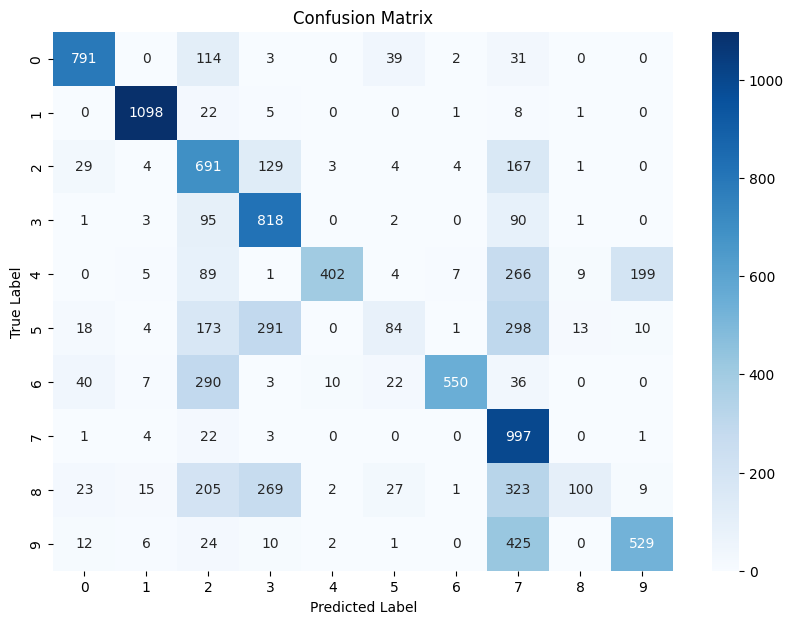

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       980
           1       0.96      0.97      0.96      1135
           2       0.40      0.67      0.50      1032
           3       0.53      0.81      0.64      1010
           4       0.96      0.41      0.57       982
           5       0.46      0.09      0.16       892
           6       0.97      0.57      0.72       958
           7       0.38      0.97      0.54      1028
           8       0.80      0.10      0.18       974
           9       0.71      0.52      0.60      1009

    accuracy                           0.61     10000
   macro avg       0.70      0.59      0.57     10000
weighted avg       0.71      0.61      0.58     10000



In [6]:
# Import necessary libraries for evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data (accuracy)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Get predictions on the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


**Analysis:**

**Strengths of RBF Networks for this Dataset:**

 1.Non-linearity:RBF networks can effectively model complex non-linear relationships between image features (pixels) and character classes. This is crucial for dealing with the variability and intricate patterns present in ancient Japanese characters.

2.Local Approximation:RBF networks perform local approximations of the input space, which can be beneficial when dealing with different character styles or distortions.

3.Interpretability:The use of RBF units with centers derived from K-means can provide some insight into the different clusters of characters in the data.

**Limitations of RBF Networks:**

1.Number of RBF Units:The performance of the network is heavily dependent on the number of RBF units. Too few units can lead to underfitting, while too many units can lead to overfitting and increased computational cost.

2.Center Initialization:The way centers are initialized significantly affects the performance of the network. Choosing inappropriate centers can result in poor generalization.

3.Training Complexity:Training RBF networks can be computationally expensive, especially when dealing with a large number of units or a complex dataset like Kuzushiji.

**How the number of RBF units affects model performance:**

* Underfitting: When the number of RBF units is too small (compared to the complexity of the dataset), the network may not be able to capture the nuances in the data, resulting in poor performance (low accuracy).

* Optimal Number of Units: There's an optimal number of RBF units that balances model complexity and generalization ability. Finding this optimal number often involves experimenting with different values and using techniques like cross-validation.

* Overfitting: When the number of RBF units is too large, the network might start to memorize the training data too well. This can lead to overfitting, where the model performs poorly on unseen data (test data). The model might become too sensitive to noise in the training data.

* In summary, the number of RBF units is a crucial hyperparameter that needs to be carefully tuned for optimal performance. Experimentation and cross-validation are essential to find the optimal number of units.**